In [1]:
import numpy as np
import pandas as pd   # pd常用于加载文件 和 格式化数据

import sklearn
from sklearn.pipeline import Pipeline   # 管道
from sklearn.preprocessing import StandardScaler   # 标准化
from sklearn.preprocessing import PolynomialFeatures   # 正则表达式处理 —— 标准化和正则都属于预处理preprocessing
from sklearn.linear_model import LinearRegression   # 线性回归

from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt

import time

In [2]:
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False

##### 1、加载数据

In [3]:
path = 'datas\household_power_consumption_1000.txt'
df = pd.read_csv(path, sep=';', low_memory=False)

names=['Date', 'Time','Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

##### 2、数据处理

In [4]:
new_df = df.replace('?', np.nan)
datas = new_df.dropna(axis=0,how = 'any')

##### 3、数据划分

In [5]:
def date_format(dt):
    import time
    t = time.strptime(' '.join(dt), '%d/%m/%Y %H:%M:%S')
    return (t.tm_year, t.tm_mon, t.tm_mday, t.tm_hour, t.tm_min, t.tm_sec)

In [38]:
X = datas[names[0:2]]   # 或使用X = datas[datas.columns[0:2]]。此外，在后面加上.values也可以
X = X.apply(lambda x: pd.Series(date_format(x)), axis=1)
Y = datas[names[4]]

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

##### 4、数据预处理 - 标准化训练

In [7]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)  # 训练并转换
X_test = ss.transform(X_test)  # 直接使用在模型构建数据上进行一个数据标准化操作 

##### 5、设置管道 + 多项式
    管道集合是一个列表，管道是一个元组列表
—— #models = [
    #Pipeline([   # 管道一
            ('Poly', PolynomialFeatures()), # 第一个操作：多项式扩展 可以理解为 Poly = PolynomialFeatures()
            ('Linear2', LinearRegression(fit_intercept=False)) # 第二个操作，线性回归
        ])
]

    Pipeline() 将多个操作合并成一个操作组，对单个操作进行声明。执行的时候，按照从前到后的顺序执行
    
Pipeline提供了两种服务：

    Convenience:只需要调用一次fit和predict就可以在数据集上训练一组estimators
    Joint parameter selection:可以把grid search用在Pipeline中所有的estimators参数的参数组合上面

Pipleline中最后一个之外的所有estimators都必须是变换器（transformers），最后一个estimator可以是任意类型（transformer，classifier，regresser）

    如果最后一个estimator是个分类器，则整个pipeline就可以作为分类器使用，如果最后一个estimator是个聚类器，则整个pipeline就可以作为聚类器使用。

—— PolynomialFeatures 多项式拓展

    degree：最高 d 次幂的扩展，默认为2
    interaction_only: 在多项式扩展过程中，是否考虑同一个特征的多次相乘；默认为False，表示扩展
    include_bias：默认为True，是否在多项式扩展的过程中，加入一个常数项，常数项值为1.默认加入

In [8]:
models = [
    Pipeline([
            ('Poly', PolynomialFeatures()), # 第一个操作：多项式扩展 可以理解为 Poly = PolynomialFeatures()
            ('Linear', LinearRegression(fit_intercept=False)) # 第二个操作，线性回归
        ])
]

model = models[0]

##### 图形属性设定

In [9]:
t=np.arange(len(X_test))

N = 5
degree = np.arange(1,N) # 4阶 [1,2,3,4]

clrs = [] # 颜色列表
for c in np.linspace(16711680, 255, N-1):   # linespace 等差数列，这里是一个逆向的等差数列。以后都这么写就行
    clrs.append('#%06x' % int(c))   # 为列表添加元素；%x 十六进制整数，06控制了占位符，用GRP颜色数值控制每一阶图像的颜色。
print(clrs)

['#ff0000', '#aa0055', '#5500aa', '#0000ff']


—— *.set_params(操作名__属性) 设置Pipeline中操作的属性。如Poly是在管道对象中定义的操作名称，后面跟参数名称；中间使用两个下划线   ★★★

—— *.get_params()[属性名] 返回Pipeline中操作的属性字典，是一个dict对象。如获取Poly属性，返回的是一个字典，通过key值再进行调用   ★★★

    -》.coef_   返回model.get_params('Linear')['Linear']的theta参数集合
    前一个Linear是管道中定义的操作名称，代表了LinearRegression
    后一个Linear表示的是字典中的key值，其返回的value表示的是具体的算法模型
    也可以简写为model.get_params['Linear']

—— *.ravel() 降为一维列向量   ★★★

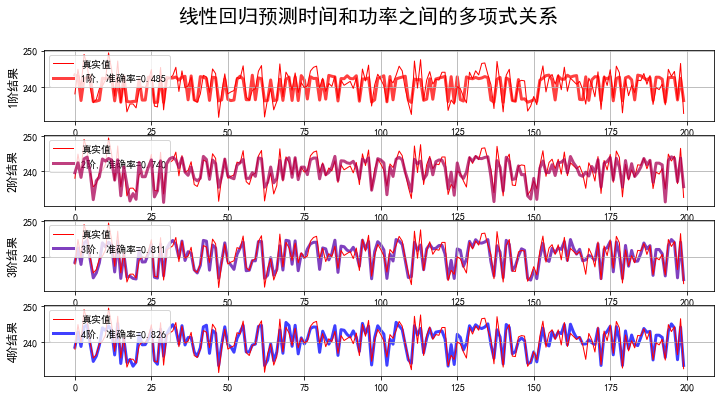

In [11]:
plt.figure(figsize=(12,6), facecolor='w')   # 创建绘图窗口，设置大小和颜色

for i,d in enumerate(degree):   # 多项式degree常与enumerate配合使用
    plt.subplot(N-1,1,i+1)   # 4行 1列 子图布局
    plt.plot(t, Y_test, 'r-', label='真实值', lw=1, zorder=N)   # 画真实情况图  markersize可简写为ms
    
    # 1、参数设定
    model.set_params(Poly__degree=d)   # 设置多项式的阶乘 d，degree是Ploy操作支持的参数，用于设置阶数。
    
    # 2、模型预处理 + 模型训练
    model.fit(X_train, Y_train)
    
    # 上面两步可以理解为 mpdel = model.set_params(Poly__degree=d).fit(X_train, Y_train)
    
    # 3、模型预测
    y_predict = model.predict(X_test)
    # 4、模型评估 R^2
    s = model.score(X_test, Y_test)
    
    # 绘制预测图
    z = N+1 if (d == 2) else 0   # 让2阶图像凸显出来，其他的图像都在测试数据图像的下方
    plt.plot(t, y_predict, color=clrs[i], linewidth=3, alpha=0.75, label='%d阶, 准确率=%.3f' % (d,s), zorder=z)   # linewidth可简写成lw
    plt.legend(loc = 'upper left')   # 设置label的位置 左上方
    
    plt.ylabel('%d阶结果' % d, fontsize=12)   # y轴侧面label
    plt.grid(True)
    
    # ————————————————————————————————————————————
#     lin = model.get_params()['Linear']
#     print (lin.coef_.ravel())   # 输出参数列表theta，并降为一维
    # 没有管道时，直接使用model.coef_就可以获取模型系数，而不需要get_params
    # ————————————————————————————————————————————
    
plt.suptitle("线性回归预测时间和功率之间的多项式关系", fontsize=20)
plt.show()

In [12]:
model.get_params()   # 字典类型 通过[ ]调用value

{'Linear': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False),
 'Linear__copy_X': True,
 'Linear__fit_intercept': False,
 'Linear__n_jobs': 1,
 'Linear__normalize': False,
 'Poly': PolynomialFeatures(degree=4, include_bias=True, interaction_only=False),
 'Poly__degree': 4,
 'Poly__include_bias': True,
 'Poly__interaction_only': False,
 'memory': None,
 'steps': [('Poly',
   PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)),
  ('Linear',
   LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False))]}

In [13]:
model.get_params()['Linear']   # 字典类型 通过[ ]调用value

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

# 管道功能分解说明
①、PolynomialFeatures的fit_transform方法对训练数据进行训练和转换

②、PolynomialFeatures的transform方法对测试数据进行转换

③、LinearRegression的fit方法构建模型

In [15]:
# 多项式预处理
pf = PolynomialFeatures(3)
X_train = pf.fit_transform(X_train) # ①
X_test = pf.transform(X_test) # ②

In [16]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train,Y_train) # ③
Y_predict = lr.predict(X_test)
score = lr.score(X_test,Y_test)
score

0.8113611177127571

##### 管道合并

In [14]:
model.set_params(Poly__degree=3)
model.fit(X_train, Y_train)   # 在调用model的fit属性时，按顺序调用Poly和Linear两个方法。对于Ploy预处理，自动对数据进行训练和转换
y_predict = model.predict(X_test)
s = model.score(X_test, Y_test)
s

0.8113611177127571